# Setup

In [1]:
!whoami

moonchild


In [2]:
 # !pip install tensorflow-gpu==2.3.0

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
%%capture
!pip install numpy==1.23.1 Pillow==9.2.0 importlib-metadata==4.11.3 matplotlib==3.5.2 scikit-learn==1.1.1 tensorboard==2.9.1 jupyter==1.0.0 ipykernel==6.9.1 seaborn==0.13.2

import sys
import os

# Add the project directory to the Python path
sys.path.append('/home/azureuser/projects/opencampus-preconditioner-ai-project')

# Change the working directory to the project directory
os.chdir('/home/azureuser/projects/opencampus-preconditioner-ai-project')
print(os.getcwd())  # Verify the change

In [5]:
import os
import scipy
import random
import importlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.sparse.linalg import gmres
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# import matrixlib
import matrixlib.core
import matrixlib.io
import matrixlib.util
import matrixlib.plot
import matrixlib.generate
from matrixlib.core import MatrixData

#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# import solvers
#import solvers.gmres

# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")


2024-06-19 14:14:42.129205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 14:14:44.875655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Path to current working directory: /home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project


In [6]:
tf.config.list_physical_devices('GPU') 

[]

2024-06-19 14:14:51.754236: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [7]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 160
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42

initialized        data vectors of size    160 x  64 x  64 =    655360 with a memory usage of   2.500 MiB
initialized  data start vectors of size    160 x  64       =     10240 with a memory usage of   0.010 MiB
initialized noise start vectors of size    160 x  64       =     10240 with a memory usage of   0.010 MiB
initialized        band vectors of size    160 x  64 x  10 =    102400 with a memory usage of   0.820 MiB


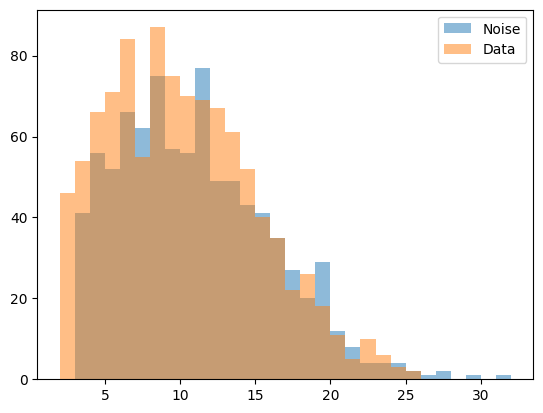

In [8]:
# Generate matrices
test_data = MatrixData(
        dimension=64,
        band_radius=10,
        sample_size=160,
        background_noise_density_range=(0.3, 0.5),
        background_noise_value_range=(0.0, 0.5),
        block_noise_density_range=(0.3, 0.5),
        block_noise_value_range=(0.3, 1.0),
        block_noise_size_range=(3, 32),
        block_noise_size_average=10,
        block_noise_size_std_dev=0.66,
        block_noise_size_gap_chance=0.5,
        block_data_density_range=(0.5, 0.7),
        block_data_value_range=(0.3, 1.0),
        block_data_size_range=(2, 32),
        block_data_size_average=10,
        block_data_size_std_dev=0.66,
        block_data_size_gap_chance=0.0,
        seed=42,
        force_invertible=False,
        print_debug=True
    )


In [9]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.block_data_start_labels
print(bands.shape, labels.shape)

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")


(160, 21, 64, 1) (160, 64)
Train size: 128, Val size: 16, Test size: 16


In [10]:
# Verfiy Shape
print(train_dataset)
print(val_dataset)
print(test_dataset)

# for element in val_dataset:
#    print(element)

<_ShuffleDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>


# Training

In [36]:
# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
num_epochs = 15
log_dir = "runs/matrix_cnn_experiment"

# Check log files
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()

Files in log directory: []


In [37]:
importlib.reload(CNN.training)

# Compile Model
model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(1),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(1),
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)

Epoch 1/15


2024-06-19 15:32:04.379027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:32:04.863955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.6260 | Validation Loss: 0.4733
Epoch 2/15


2024-06-19 15:32:44.817041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:32:45.262504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3918 | Validation Loss: 0.3499
Epoch 3/15


2024-06-19 15:33:17.318923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:33:18.050690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3384 | Validation Loss: 0.3246
Epoch 4/15


2024-06-19 15:34:00.471054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:34:00.983164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3200 | Validation Loss: 0.3139
Epoch 5/15


2024-06-19 15:34:38.402301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:34:38.900497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3093 | Validation Loss: 0.3079
Epoch 6/15


2024-06-19 15:35:15.493379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:35:15.976560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.3018 | Validation Loss: 0.3038
Epoch 7/15


2024-06-19 15:35:56.662950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:35:57.555336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2984 | Validation Loss: 0.3014
Epoch 8/15


2024-06-19 15:36:31.768206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:36:32.476815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2917 | Validation Loss: 0.2994
Epoch 9/15


2024-06-19 15:37:03.464399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:37:03.908789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2889 | Validation Loss: 0.2975
Epoch 10/15


2024-06-19 15:37:32.335634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:37:32.788804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2857 | Validation Loss: 0.2962
Epoch 11/15


2024-06-19 15:38:02.811270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:38:03.327929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2810 | Validation Loss: 0.2949
Epoch 12/15


2024-06-19 15:38:34.023506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:38:34.494095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2750 | Validation Loss: 0.2937
Epoch 13/15


2024-06-19 15:39:04.100202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:39:04.590012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2701 | Validation Loss: 0.2924
Epoch 14/15


2024-06-19 15:39:36.079752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:39:36.568087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2638 | Validation Loss: 0.2912
Epoch 15/15


2024-06-19 15:40:06.620579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-19 15:40:07.087403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.2596 | Validation Loss: 0.2899
Restoring model weights from the end of the best epoch: 15.


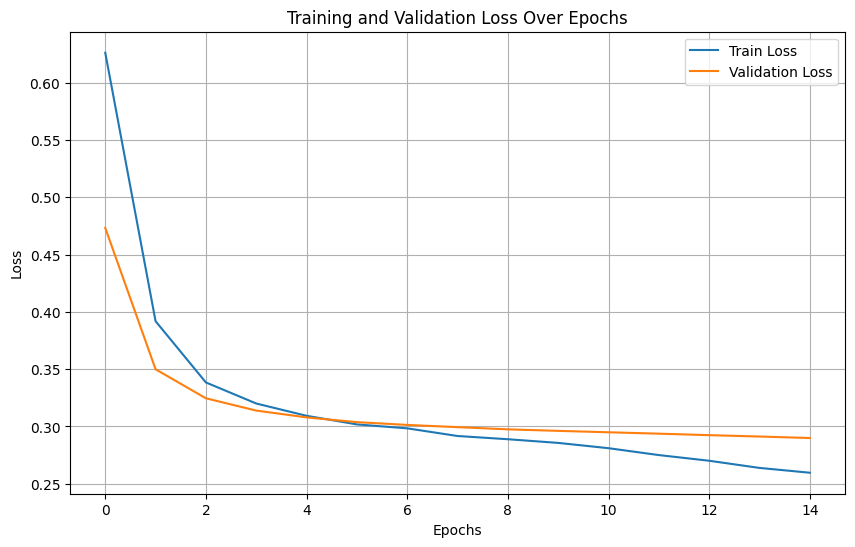

In [38]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [50]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

True Labels Shape: (1024,)
Predicted Labels Shape: (1024,)
Test Loss: 0.2860
Accuracy: 0.9141
Precision: 0.9216
Recall: 0.9141
F1 Score: 0.8845


2024-06-19 15:45:56.901414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
# Restore weights from best run
restored_model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
latest = tf.train.latest_checkpoint(log_dir)
restored_model.load_weights(latest)

# Evaluate the restored model
restored_results = CNN.evaluation.evaluate_model(
    model=restored_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

ValueError: File format not supported: filepath=None. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [49]:
# Restore the model weights from the checkpoint
restored_model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=restored_model)
checkpoint.restore(tf.train.latest_checkpoint(log_dir)).expect_partial()

# Evaluate the restored model
restored_results = CNN.evaluation.evaluate_model(
    model=restored_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

True Labels Shape: (1024,)
Predicted Labels Shape: (1024,)
Test Loss: 0.7498
Accuracy: 0.4688
Precision: 0.8108
Recall: 0.4688
F1 Score: 0.5656


2024-06-19 15:45:51.523401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Prediction

In [19]:
# Extract test matrices and labels from dataset
test_bands = bands[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(1))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Overall Accuracy:
0.9140625


# Create Block Jacobi Preconditioner

In [ ]:
print(test_bands.shape)
print(binary_predictions.shape)

In [ ]:
def block_jacobi_preconditioner_from_predictions(A, binary_predictions):
    """
    Calculates the block Jacobi preconditioner for each 2D matrix in a 3D array using binary predictions for block starts.

    Args:
        A: NumPy array of shape (n, m, m) representing n square matrices of size m x m.
        binary_predictions: NumPy array of shape (n, m) where each row indicates block starts with 1s.

    Returns:
        A NumPy array of the same shape as A representing the block diagonal preconditioner for each 2D matrix.
    """
    n, m, _ = A.shape
    
    # Initialize the preconditioner array
    prec = np.zeros_like(A)
    
    for k in range(n):
        # Find block start indices from binary predictions
        block_starts = np.where(binary_predictions[k] == 1)[0]
        
        # Ensure to include the end of the matrix as a block end
        block_starts = np.append(block_starts, m)
        
        # Extract diagonal blocks
        blocks = []
        for i in range(len(block_starts) - 1):
            start = block_starts[i]
            end = block_starts[i + 1]
            blocks.append(A[k, start:end, start:end])
        
        # Invert diagonal blocks if they are invertible
        inv_blocks = []
        for block in blocks:
            try:
                inv_block = np.linalg.inv(block)
            except np.linalg.LinAlgError:
                # Use pseudoinverse if the block is singular
                inv_block = np.linalg.pinv(block)
            inv_blocks.append(inv_block)
        
        # Create block diagonal matrix for the k-th matrix
        for i, block in enumerate(inv_blocks):
            start = block_starts[i]
            end = block_starts[i + 1]
            prec[k, start:end, start:end] = block
    
    return prec

In [ ]:
# Create preconditioner
prec = block_jacobi_preconditioner_from_predictions(test_matrices, binary_predictions)

print("Original Matrix A (first instance):")
print(A[0])
print("\nBlock Jacobi Preconditioner (first instance):")
print(prec[0])

# GMRES Solver

## Check Condition Number before Preconditioning

In [ ]:
print(test_labels.shape)
print(test_labels[0])

In [ ]:
def check_condition_number(matrix):
    try:
        condition_number = np.linalg.cond(matrix)
    except np.linalg.LinAlgError:
        condition_number = float('inf')
    return condition_number

check_condition_number(test_matrices[0])


In [ ]:

# Convert test_labels to integer indices
block_starts = np.where(test_labels[0] == 1)[0]

# Check condition numbers
for i, matrix in enumerate(test_matrices):
    condition_number = check_condition_number(matrix)
    print(f"Condition number of matrix {i}: {condition_number}")
    block_starts = np.where(binary_predictions[i] == 1)[0]
    block_starts = np.append(block_starts, matrix.shape[0])
    for j in range(len(block_starts) - 1):
        start = block_starts[j]
        end = block_starts[j + 1]
        block = matrix[start:end, start:end]
        block_condition_number = check_condition_number(block)
        print(f"Condition number of block {j} of matrix {i}: {block_condition_number}")
        prec_block = prec[i, start:end, start:end]
        prec_block_condition_number = check_condition_number(prec_block)
        print(f"Condition number of preconditioner block {j} of matrix {i}: {prec_block_condition_number}")

print("Original Matrix A (first instance):")
print(test_matrices[0])
print("\nBlock Jacobi Preconditioner (first instance):")
print(prec[0])

In [ ]:
# Run GMRES solver on unconditioned matrices
from scipy.sparse.linalg import gmres

# Define parameters
maxit = 100
tol = 1e-5

solutions_no_preconditioner = []  # List to store solution vectors for all matrices


for i, matrix in enumerate(test_matrices):
    # Convert matrix to sparse format
    A_sparse = scipy.sparse.csr_matrix(matrix)

    # Define right-hand side as a vector of ones
    b = np.ones(matrix.shape[0])

    # Extract the corresponding preconditioner for this matrix
    preconditioner_matrix = scipy.sparse.csr_matrix(prec[i])

    # Run GMRES solver
    x, iteration_number = gmres(A_sparse, b, M=preconditioner_matrix, tol=tol, maxiter=maxit)
    solutions_no_preconditioner.append(x)
    print(f"Matrix {i} solved in {iteration_number}")




In [ ]:
solutions_with_preconditioner = []  

for i, matrix in enumerate(test_matrices):
    # Convert matrix to sparse format
    A_sparse = scipy.sparse.csr_matrix(matrix)

    # Define right-hand side as a vector of ones
    b = np.ones(matrix.shape[0])

    # Extract the corresponding preconditioner for this matrix
    preconditioner_matrix = scipy.sparse.csr_matrix(prec[i])

    # Run GMRES solver
    x, exit_code = gmres(A_sparse, b, M=preconditioner_matrix, tol=1e-1, maxiter=5000)
    solutions_with_preconditioner.append(x)
    print(f"Matrix {i} solved with exit code {exit_code}")

print("All matrices solved with preconditioner.")

In [ ]:
while True:
    pass